# Gomoku game

1. [DONE] Implement a Gomoku game rule class, which checks whether a position is the end of the game.
2. [DONE] Implement a greedy rule based player, which puts the stone on one of the available points where creates the maximum number of 5s, 4s, 3s and 2s, and prevent the opponent to have 5s and 4s.
3. [DONE] Implement a human player UI that can play with the greedy player.
4. Use supervised learning to learn the greedy rule based player.
5. Use the human player UI to play with the learned player.
6. Implement a batch AI vs. AI simulation to evaluate the performance of the learned player.
7. Use reinforcement learning to learn a play policy against itself starting from the policy of supervise learning.
8. Use reinforcement learning to learn a play policy against itself starting from a random policy. This might take long time to converge.

In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
NUM_IN_ROW_TO_WIN = 5
BOARD_LENGTH = 11

In [3]:
def spiral_order(length) -> npt.ArrayLike:
  assert length % 2 == 1, "spiral_order only works for odd length"
  spiral_order = np.zeros([length, length], dtype=np.int64)
  x, y = length // 2, length // 2
  dx, dy = 0, 1
  try:
    for i in range(length * length):
      spiral_order[x, y] = i + 1
      if spiral_order[x + dy, y - dx] == 0:  # x + dx >= length or x + dx < 0 or y + dy >= length or y + dy < 0 or 
        dx, dy = dy, -dx
      x, y = x + dx, y + dy
  except IndexError:
    print(f"IndexError at {x}, {y}, i={i}, spiral_order={spiral_order}")
  return spiral_order

spiral_order(BOARD_LENGTH)

array([[101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111],
       [100,  65,  66,  67,  68,  69,  70,  71,  72,  73, 112],
       [ 99,  64,  37,  38,  39,  40,  41,  42,  43,  74, 113],
       [ 98,  63,  36,  17,  18,  19,  20,  21,  44,  75, 114],
       [ 97,  62,  35,  16,   5,   6,   7,  22,  45,  76, 115],
       [ 96,  61,  34,  15,   4,   1,   8,  23,  46,  77, 116],
       [ 95,  60,  33,  14,   3,   2,   9,  24,  47,  78, 117],
       [ 94,  59,  32,  13,  12,  11,  10,  25,  48,  79, 118],
       [ 93,  58,  31,  30,  29,  28,  27,  26,  49,  80, 119],
       [ 92,  57,  56,  55,  54,  53,  52,  51,  50,  81, 120],
       [ 91,  90,  89,  88,  87,  86,  85,  84,  83,  82, 121]])

In [4]:
def is_win(
    position: npt.ArrayLike,
    point: npt.ArrayLike,
  ) -> bool:
  '''Check whether the position is at a terminating status.
  Args:
    position: A ndarray of shape [B, BOARD_LENGTH, BOARD_LENGTH] which has value 0, 1, and 2 for each element.
      0 means the point is not ocupied and available to play on. 1 mean that the point is taken by player 1,
      and 2 means that the point is taken by player 2.
    point: A ndarray [B, 2], which carries the 0-based row and column of the point that is last played. The
      position should be already updated with the last play, which means that position[point] should be either
      1 or 2 and cannot be 0.
  '''
  
  # check row
  x_len = 1
  for y_diff in range(1, NUM_IN_ROW_TO_WIN):
    if point[1] + y_diff < BOARD_LENGTH and position[point[0], point[1] + y_diff] == position[point[0], point[1]]:
      x_len += 1
    else:
      break
  for y_diff in range(-1, -NUM_IN_ROW_TO_WIN, -1):
    if point[1] + y_diff >= 0 and position[point[0], point[1] + y_diff] == position[point[0], point[1]]:
      x_len += 1
    else:
      break
  if x_len >= NUM_IN_ROW_TO_WIN:
    return True
  
  # check column
  y_len = 1
  for x_diff in range(1, NUM_IN_ROW_TO_WIN):
    if point[0] + x_diff < BOARD_LENGTH and position[point[0] + x_diff, point[1]] == position[point[0], point[1]]:
      y_len += 1
    else:
      break
  for x_diff in range(-1, -NUM_IN_ROW_TO_WIN, -1):
    if point[0] + x_diff >= 0 and position[point[0] + x_diff, point[1]] == position[point[0], point[1]]:
      y_len += 1
    else:
      break
  if y_len >= NUM_IN_ROW_TO_WIN:
    return True

  # check top-right bottom-left diagonal
  diag_len = 1
  for diff in range(1, NUM_IN_ROW_TO_WIN):
    if point[0] + diff < BOARD_LENGTH and point[1] + diff < BOARD_LENGTH and position[point[0] + diff, point[1] + diff] == position[point[0], point[1]]:
      diag_len += 1
    else:
      break
  for diff in range(-1, -NUM_IN_ROW_TO_WIN, -1):
    if point[0] + diff >= 0 and point[1] + diff >= 0 and position[point[0] + diff, point[1] + diff] == position[point[0], point[1]]:
      diag_len += 1
    else:
      break
  if diag_len >= NUM_IN_ROW_TO_WIN:
    return True

  # check top-left bottom-right diagonal
  diag_len = 1
  for diff in range(1, NUM_IN_ROW_TO_WIN):
    if point[0] + diff < BOARD_LENGTH and point[1] - diff >= 0 and position[point[0] + diff, point[1] - diff] == position[point[0], point[1]]:
      diag_len += 1
    else:
      break
  for diff in range(-1, -NUM_IN_ROW_TO_WIN, -1):
    if point[0] + diff >= 0 and point[1] - diff < BOARD_LENGTH and position[point[0] + diff, point[1] - diff] == position[point[0], point[1]]:
      diag_len += 1
    else:
      break
  if diag_len >= NUM_IN_ROW_TO_WIN:
    return True

  return False


def test_is_win():
  position = np.zeros([BOARD_LENGTH, BOARD_LENGTH], dtype=np.int32)
  position[0, 0] = 1
  position[1, 0] = 1
  position[2, 0] = 1
  position[3, 0] = 1
  position[4, 0] = 1
  assert is_win(position, np.array([4, 0]))
  position[4, 0] = 0
  position[0, 0] = 0
  position[0, 1] = 1
  position[0, 2] = 1
  position[0, 3] = 1
  position[0, 4] = 1
  position[0, 5] = 1
  assert is_win(position, np.array([0, 3]))
  position[0, 0] = 1
  position[1, 1] = 1
  position[2, 2] = 1
  position[3, 3] = 1
  position[4, 4] = 1
  assert is_win(position, np.array([1, 1]))
  position[4, 4] = 0
  position[5, 4] = 2
  position[6, 3] = 2
  position[7, 2] = 2
  position[8, 1] = 2
  position[9, 0] = 2
  assert is_win(position, np.array([9, 0]))
  assert not is_win(position, np.array([3, 0]))
  print('All test passed!')


test_is_win()

All test passed!


In [5]:
# use a spiral order to break ties
break_tie = spiral_order(BOARD_LENGTH) * -0.00001

def greedy_play(
    position: npt.ArrayLike,
    player: int,
) -> npt.ArrayLike | None:
  '''Given the current position, return the next play for the player.
  Args:
    position: A ndarray of shape [BOARD_LENGTH, BOARD_LENGTH] which has value 0, 1, and 2 for each element.
      0 means the point is not ocupied and available to play on. 1 mean that the point is taken by player 1,
      and 2 means that the point is taken by player 2.
    player: An integer, 1 or 2, which indicates the player to play next.
  Returns:
    A ndarray of shape [2], which carries the 0-based row and column of the point that the player should play.
    If the player cannot play anywhere, return None.
  '''
  # Score every empty point on the board:
  # For the 5 consecutive points starting from the point on one of the 4 directions (right, right-down, down, left-down):
  #   1. If the last point of the 5 is out of the board, skip.
  #   2. If both players have taken at least one of the 5 points, skip.
  #   3. If 4/3/2/1 point(s) are alreay taken by the player, score at the empty positions +100000/1000/10/1.
  #   4. If 4/3/2/1 point(s) are alreay taken by the other player, score at the empty positions +10000/100/1/0.1.
  # return the point with the highest score. If there is a tie, return the point closest to the center of the board.
  # If there is a tie, return the one with the smallest row.
  # If still tie, return the one with the smallest column.

  scores = break_tie.copy()
  for dx, dy in [(0, 1), (1, 1), (1, 0), (1, -1)]:
    counts_x = BOARD_LENGTH - (NUM_IN_ROW_TO_WIN - 1) * abs(dx)
    counts_y = BOARD_LENGTH - (NUM_IN_ROW_TO_WIN - 1) * abs(dy)
    def _ith_on_direction(board, i):
      x_begin = dx * i
      y_begin = dy * i if dy >= 0 else dy * i + NUM_IN_ROW_TO_WIN - 1
      return board[x_begin: x_begin + counts_x, y_begin: y_begin + counts_y]
    
    # First calculate scores for potential 5s taken by the player
    count_begin_at = np.zeros([counts_x, counts_y], dtype=np.int64)
    for i in range(NUM_IN_ROW_TO_WIN):
      # if player, +1, if other player, -100, otherwise 0
      position_view = _ith_on_direction(position, i)
      count_begin_at += np.where(position_view == player, 1, 0)
      count_begin_at -= np.where(position_view == 3 - player, 100, 0)
    for i in range(NUM_IN_ROW_TO_WIN):
      score_view = _ith_on_direction(scores, i)
      # no need to pay attention to the points that are already taken here. We deal with them before the return.
      score_view += np.where(count_begin_at == 4, 100000, 0)
      score_view += np.where(count_begin_at == 3, 1000, 0)
      score_view += np.where(count_begin_at == 2, 10, 0)
      score_view += np.where(count_begin_at == 1, 1, 0)
    
    # # Then calculate scores for potential 5s taken by the other player
    count_begin_at = np.zeros([counts_x, counts_y], dtype=np.int64)
    for i in range(NUM_IN_ROW_TO_WIN):
      position_view = _ith_on_direction(position, i)
      count_begin_at += np.where(position_view == 3 - player, 1, 0)
      count_begin_at -= np.where(position_view == player, 100, 0)
    for i in range(NUM_IN_ROW_TO_WIN):
      score_view = _ith_on_direction(scores, i)
      score_view += np.where(count_begin_at == 4, 10000, 0)
      score_view += np.where(count_begin_at == 3, 100, 0)
      score_view += np.where(count_begin_at == 2, 1, 0)
      score_view += np.where(count_begin_at == 1, 0.1, 0)

  # only count the scores for empty positions
  scores[position != 0] = -1000000
  return np.unravel_index(np.argmax(scores, axis=None), scores.shape)


def test_greedy_play():
  position = np.zeros([BOARD_LENGTH, BOARD_LENGTH], dtype=np.int32)
  position[1, 0] = 1
  position[2, 0] = 1
  position[3, 0] = 1
  
  assert np.all(greedy_play(position, 1) == np.array([4, 0]))
  # TODO: add more tests
  print('All test passed!')


test_greedy_play()

All test passed!


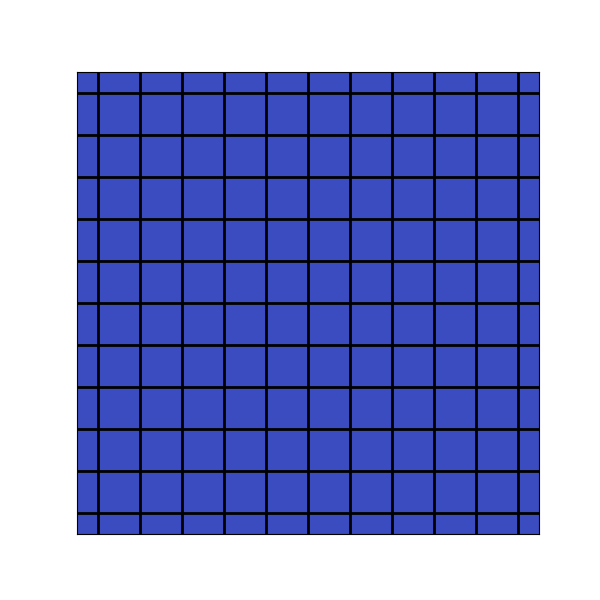

Player plays at 6, 3
AI plays at 6, 4
Player plays at 5, 4
AI plays at 5, 3
Player plays at 4, 5
AI plays at 3, 6
Player plays at 6, 5
AI plays at 7, 2
Player plays at 7, 4
AI plays at 7, 5
Player plays at 4, 2
AI plays at 8, 6
Player plays at 9, 7
AI plays at 4, 6
Player plays at 5, 6
AI plays at 4, 7
Player plays at 4, 3
AI plays at 7, 6
Player plays at 5, 2
AI plays at 4, 1
Player plays at 3, 2
AI plays at 2, 1
Player plays at 2, 2
AI plays at 1, 2
Player plays at 6, 2
Player wins!


In [6]:
%matplotlib widget

class Play(object):
  def __init__(self, *, ai_player=None):
    self.ai_player = ai_player
    self.position = np.zeros([BOARD_LENGTH, BOARD_LENGTH], dtype=np.int32)
    self.fig = None
    self.cid = None

  def update_board(self, event):
    x, y = int(event.xdata), int(event.ydata)
    if x < 0 or x >= BOARD_LENGTH or y < 0 or y >= BOARD_LENGTH:
        print("Out of board click. X=", x, "Y=", y)
        return
    if self.position[x, y] != 0:  # If the clicked cell is empty
        return
    
    self.position[x, y] = 1  # Place the player's piece
    print(f"Player plays at {x}, {y}")
    plt.plot(x + 0.5, y + 0.5, 'ro', markersize=20)
    plt.draw()
    # Check for win after updating the board
    if is_win(self.position, (x, y)):
        print(f"Player wins!")
        self.fig.canvas.mpl_disconnect(self.cid)  # Disable further clicks
        return

    ai_x, ai_y = self.ai_player(self.position, 2)
    assert self.position[ai_x, ai_y] == 0, f"AI player tried to play at {ai_x}, {ai_y} which is already taken."
    self.position[ai_x, ai_y] = 2
    print(f"AI plays at {ai_x}, {ai_y}")
    plt.plot(ai_x + 0.5, ai_y + 0.5, 'go', markersize=20)
    plt.draw()
    # Check for win after updating the board
    if is_win(self.position, (ai_x, ai_y)):
        print(f"AI wins!")
        self.fig.canvas.mpl_disconnect(self.cid)  # Disable further clicks
        return

  def display_board(self):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xticks(np.arange(BOARD_LENGTH) + 0.5, minor=True)
    ax.set_yticks(np.arange(BOARD_LENGTH) + 0.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", size=0)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(self.position, cmap='coolwarm', extent=[0, BOARD_LENGTH, 0, BOARD_LENGTH])
    plt.gca().invert_yaxis()
    self.fig = fig
    self.cid = fig.canvas.mpl_connect('button_press_event', self.update_board)
    plt.show()


play = Play(ai_player=greedy_play)
play.display_board()